## Import Libraries

In [2]:
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.config import get_cfg 
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog


In [3]:
import json
import os
import sys
import random 
import PIL
import matplotlib.pyplot as plt 
import cv2
import numpy as np


## Global Variables

In [4]:
ROOT = os.path.abspath('../')
DATA_FOLDER = 'imagenet/data/test/box'
CONFIG = 'mask_rcnn/config'
WEIGHTS = 'mask_rcnn/weights'
DEVICE = 'cpu'

## Helper Functions 

In [24]:
# def read_json(file_name, path):
#     file_path = os.path.join(ROOT, path,file_name)
#     try:
#         with open(file_path) as annotations:
#             data = json.load(annotations)
#     except:
#         print("LOG: Not file found")
#     return data

# def show_images():
#     path = os.path.join(ROOT, DATA_FOLDER)
#     annotations = read_json('via_project_3Jun2020_12h29m.json',DATA_FOLDER)
#     files = annotations['_via_img_metadata']
#     row,col = 2,2
#     for num, x in enumerate(files):
#         if num == row*col:
#             break
#         img = PIL.Image.open(os.path.join(path, files[x]['filename']))
#         plt.subplot(row,col,num+1)
#         plt.title(x.split('.')[0])
#         plt.axis('off')
#         plt.imshow(img)

# def show_images_with_bb():
#     annotations = read_json('dataset_mask_full_no_aug.json',DATA_FOLDER)
#     files = annotations['_via_img_metadata']
#     for d in random.sample(list(files.values()), 3):
#         img = cv2.imread(os.path.join(ROOT,DATA_FOLDER,d["filename"]))
#         print(img)
#         visualizer = Visualizer(img[:, :, ::-1], metadata=data, scale=0.5)
#         vis = visualizer.draw_dataset_dict(d)
#         cv2_imshow(vis.get_image()[:, :, ::-1])

In [28]:



def get_carplate_dicts(mode):
    ROOT = os.path.abspath('../')
    DATA_FOLDER = 'mask_rcnn/plates_with_json'
    path = os.path.join(ROOT, DATA_FOLDER)
    json_file = os.path.join(path, "dataset_mask_full_no_aug.json")
    with open(json_file, encoding='utf-8') as f:
        imgs_anns = json.load(f)
    
    dataset_dicts = []
    dataset_len = len(list(imgs_anns['_via_img_metadata'].values()))
    dataset = list(imgs_anns['_via_img_metadata'].values())
    
    dataset = [img for img in dataset if  img['regions']]
    
    if mode == 'train':
        dataset = dataset[:dataset_len - int(dataset_len*0.1)]
    elif mode == 'val':
        dataset = dataset[dataset_len - int(dataset_len*0.1):]
    for idx, v in enumerate(list(dataset)):
        record = {}
        
        filename = os.path.join(path, v["filename"])
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        annos = v["regions"]
        
        objs = []
        for anno in annos:
#             assert not anno["region_attributes"]
            # class_id = anno["region_attributes"]["type"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]
            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts


## Prepare Dataset

In [29]:
dataset_dicts = get_carplate_dicts('train')

In [7]:
DatasetCatalog.register("carplate_train", lambda x='train':  get_carplate_dicts(x))
DatasetCatalog.register("carplate_val", lambda x='val':  get_carplate_dicts(x))
MetadataCatalog.get("carplate_val").set(thing_classes=["box"])
carplate_metadata = MetadataCatalog.get("carplate_val")

MetadataCatalog.get("carplate_val").set(evaluator_type='coco')



Metadata(evaluator_type='coco', name='carplate_val', thing_classes=['box'])

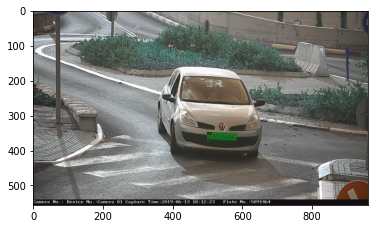

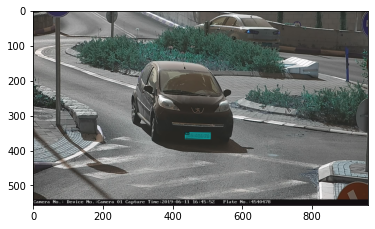

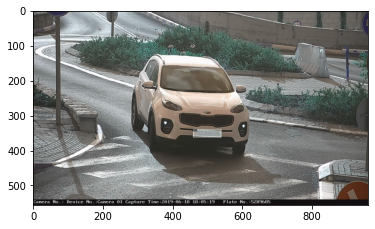

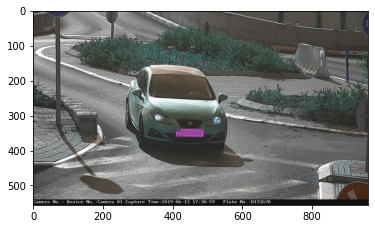

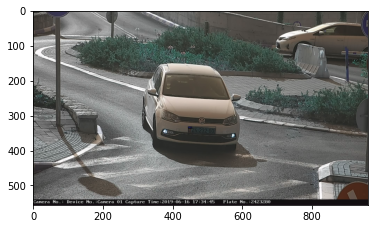

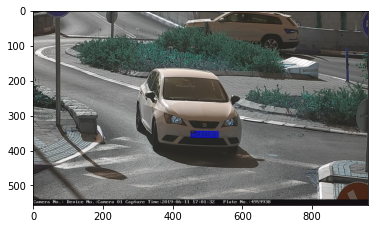

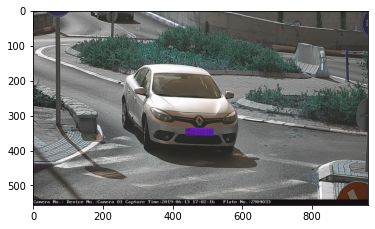

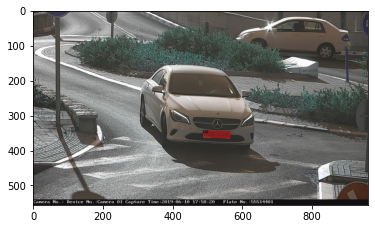

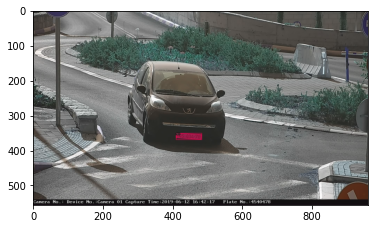

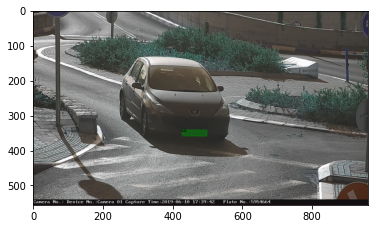

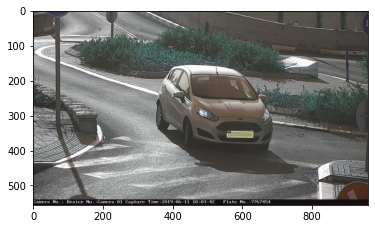

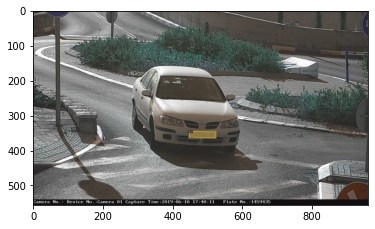

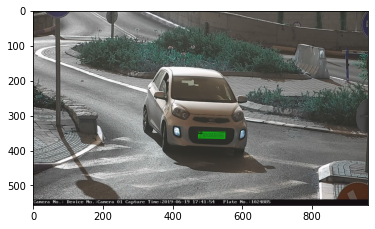

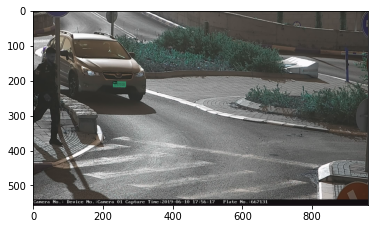

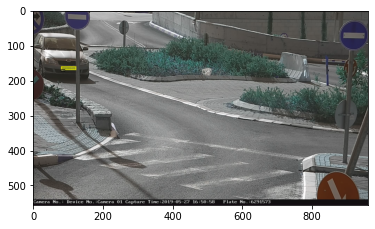

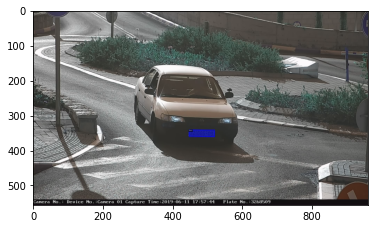

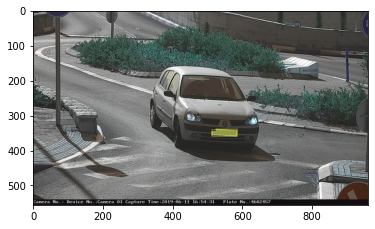

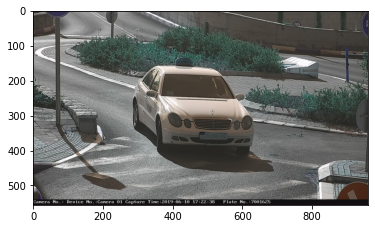

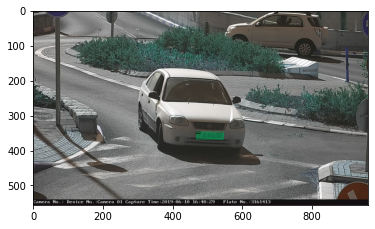

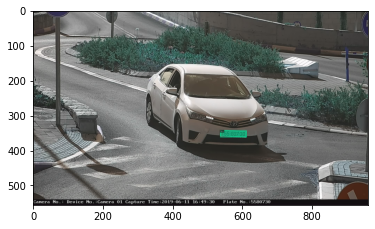

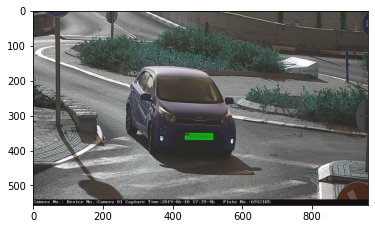

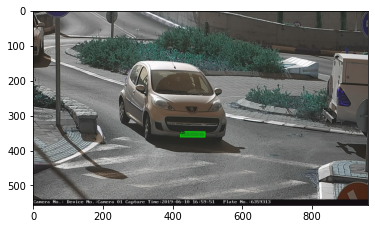

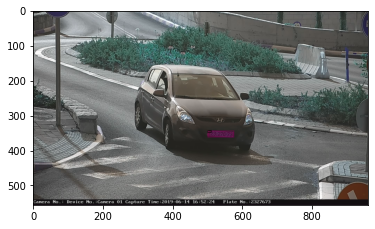

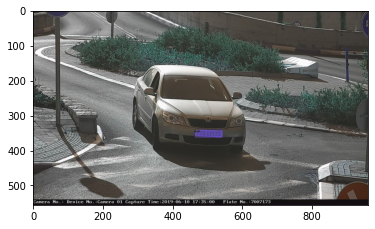

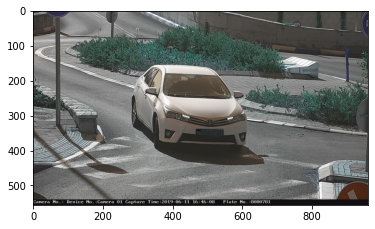

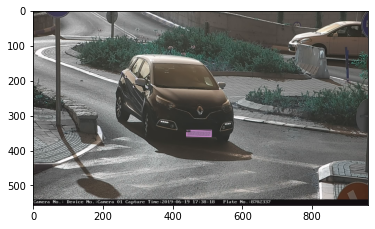

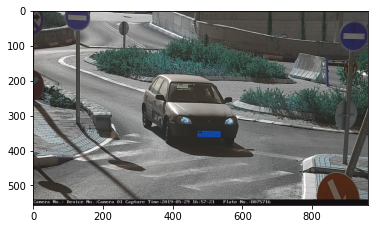

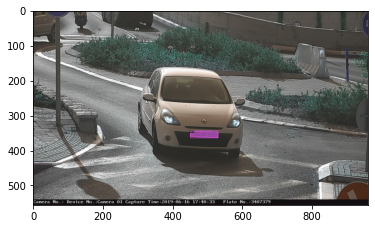

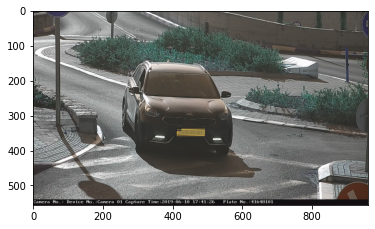

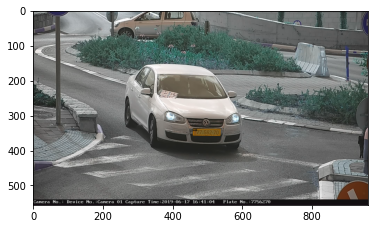

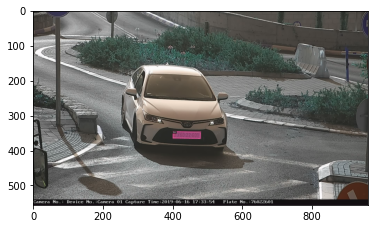

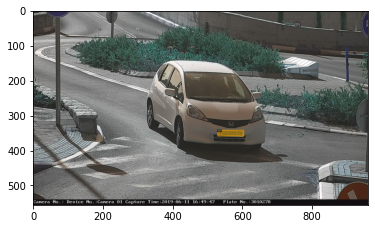

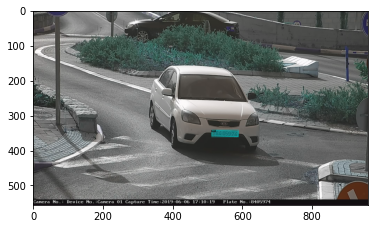

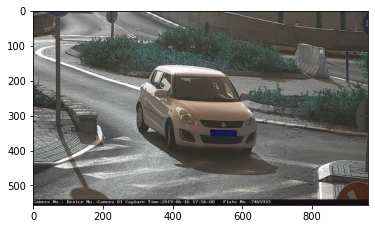

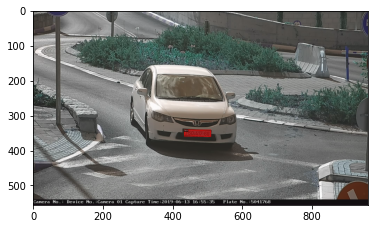

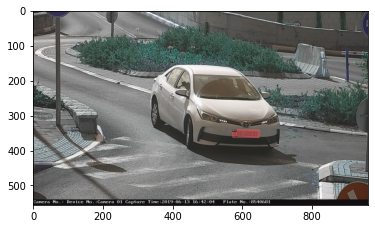

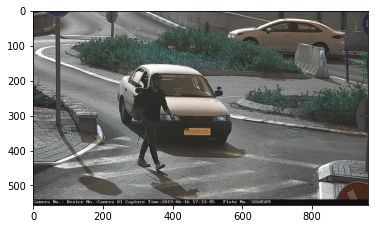

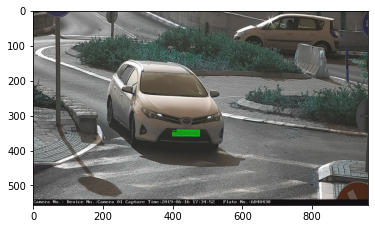

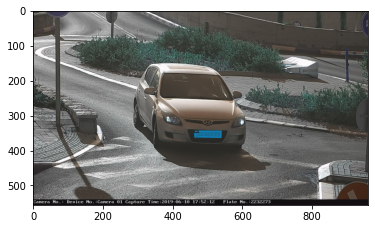

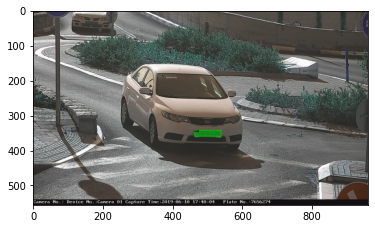

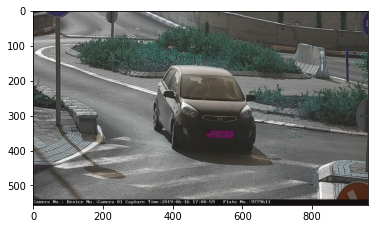

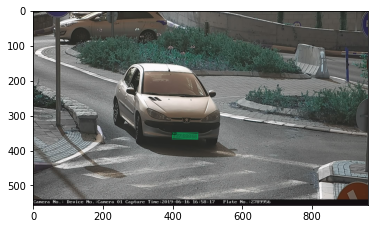

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [30]:

for d in dataset_dicts:
    window_name = 'image'
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=carplate_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()

## Train Model

In [22]:
cfg = get_cfg()
cfg.merge_from_file(os.path.join(ROOT, 'mask_rcnn/config', "mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.DEVICE = 'cpu'
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon)

cfg.MODEL.WEIGHTS = os.path.join(ROOT, 'mask_rcnn/weights', "mask_rcnn_model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model

## Inference 

In [23]:

predictor = DefaultPredictor(cfg)

In [44]:
image = cv2.imread('images/IMG_0416.JPG')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [45]:
outputs = predictor(image)
outputs

{'instances': Instances(num_instances=1, image_height=3024, image_width=4032, fields=[pred_boxes: Boxes(tensor([[1705.5903,  125.4136, 3271.2986, 1876.2388]])), scores: tensor([1.0000]), pred_classes: tensor([0]), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False]]])])}

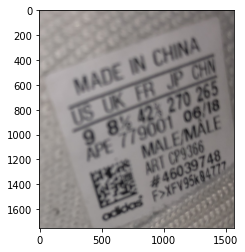

In [46]:
bbox = outputs["instances"].pred_boxes.tensor.numpy()
img = image[int(bbox[0][1]):int(bbox[0][3]),int(bbox[0][0]):int(bbox[0][2])]
plt.imshow(img)
